# The Refinery Files 0x0B: Flare On 12

This tutorial is a refinery-focused summary of my solutions for [FlareOn][] Vol.12.
As in the [previous tutorial][F11], it will not explore the reverse engineering of the individual challenges quite that much.

> **⚠️ WARNING**  
> This writeup is work in progress.

[FlareOn]: https://flare-on.com/
[F11]: tbr-files.v0x0a.flare.on.11.ipynb

In [1]:
import tutorials.boilerplate

# Challenge 1 - Drill Baby Drill

In [2]:
%flare v12/1.DrillBabyDrill.7z DrillBabyDrill.py README.txt

11.426 kB 0b67d587b9edf94182f7b844e293bba86ba4103c511664dd7d76aefde4103216 DrillBabyDrill.py
00.414 kB 616195c0c0c26f07a26188d609bf5f428bba3b2492403e7fc3abdbb05cbd30be README.txt


In [3]:
%emit README.txt | resplit [| pick :2 ]]

This game is written in PyGame. It is about a baby trying to drill to recover its lost teddy bears.
The source code is provided, as well as a runnable pyinstaller EXE file.


Sounds pretty straightforward.
As always with the first FlareOn challenge, this is mostly a glorified captcha and it is very easy to obtain the flag.
First, let's carve the largest string literal from the source code:

In [4]:
%emit DrillBabyDrill.py | csb str | peek -rd

---------------------------------------------------------------------------------------------------------------[utf8]---
"\xd0\xc7\xdf\xdb\xd4\xd0\xd4\xdc\xe3\xdb\xd1\xcd\x9f\xb5\xa7\xa7\xa0\xac\xa3\xb4\x88\xaf\xa6\xaa\xbe\xa8\xe3\xa0\xbe...
------------------------------------------------------------------------------------------------------------------------


We use [csb][], which is a shortcut for using [carve][] with the `-s` switch; it extracts the single largest substring that matches the `str` format type, which represents string literals. The result certainly looks like the encrypted flag. The code to decrypt it looks as follows:
```python
for i in range(0, len(encoded)):
    plaintext.append(chr(ord(encoded[i]) ^ (key+i)))
```
We can use [alu][] to replicate this simple string encryption easily.
You could recover the key from knowing that the last letter must decrypt to an `m`,
but you can just as easily brute force it for all possible byte values:

[alu]: https://binref.github.io/#refinery.alu
[csb]: https://binref.github.io/#refinery.csb
[carve]: https://binref.github.io/#refinery.carve

In [5]:
%emit DrillBabyDrill.py | csd string | rep 256 [| alu B@(index+K) | xtp email ]]

drilling_for_teddies@flare-on.com


# Challenge 2 - Project Chimera

In [6]:
%flare v12/2.project_chimera.7z

08.405 kB ec97051db58057166c5aa5db7b59f76be629bfe6a1c2e97a5be63059d7e32e02 project_chimera.py


We have to reverse engineer a packed Python script.
The first layer is a sequence of zlib-decompression and unmarshaling;
here's a [peek][] at the code without the useless comments;
It first uses [resplit][] to split the input at line breaks, and then filters out all lines that contain a comment using [iffx][] within the [frame][]. The unit [sep][] re-inserts line breaks before fusing the lines at the end of that frame, and [trim][] strips all surrounding whitespace of the document.

[resplit]: https://binref.github.io/#refinery.resplit
[iffx]: https://binref.github.io/#refinery.iffx
[sep]: https://binref.github.io/#refinery.sep
[trim]: https://binref.github.io/#refinery.trim
[peek]: https://binref.github.io/#refinery.peek
[frame]: https://binref.github.io/lib/frame.html

In [7]:
%emit project_chimera.py | resplit [[| iffx -R "^#" | sep ]| trim | peek -rda ]

---------------------------------------------------------------------------------------------------------------[utf8]---
import zlib
import marshal

encrypted_sequencer_data = b'x\x9cm\x96K\xcf\xe2\xe6\x15\xc7\xfd\xcedf\x92\xe6\xd2J\x93\xceTI\x9b\x8c\x05&\x18\xe4\t\...

print(f"Booting up {f"Project Chimera"} from Dr. Khem's journal...")
sequencer_code = zlib.decompress(encrypted_sequencer_data)
exec(marshal.loads(sequencer_code))


------------------------------------------------------------------------------------------------------------------------


We use [csd][], another shortcut for [carve][], which includes both the `-s` and `-d` switches.
The former means to carve the single largest buffer, while `-d` instructs the unit to decode the buffer.
For a string literal, this means to remove the surrounding quotes and resolve any escape sequences.
Then, we use [zl][] to decompress the buffer.
There is also a refinery unit [pym][] for unmarshaling which attempts to dump code objects with the correct magic.
This doesn't always work well, but after tweaking the unit during Flare On, it should definitely continue to work for this specific sample as I'm adding a regression test for it:


[csd]: https://binref.github.io/#refinery.csd
[carve]: https://binref.github.io/#refinery.carve
[pym]: https://binref.github.io/#refinery.pym
[zl]: https://binref.github.io/#refinery.zl

In [8]:
%emit project_chimera.py | csd str | zl | pym | dump stage1.pyc

In [9]:
%ls

08.405 kB ec97051db58057166c5aa5db7b59f76be629bfe6a1c2e97a5be63059d7e32e02 project_chimera.py
03.051 kB 011567a1ed257f8474d036310df58e1f24e0f7b9a26855fbbdfb6e08d6c483b0 stage1.pyc


There are generally two Python decompilers that work for recent Python versions; one is [pycdc][], the other is [pylingual][].
In this case, [pycdc][] works only for the first stage, but both stages decompile well under [pylingual][].
The decompilation for the first stage looks as follows:
```python
import base64
import zlib
import marshal
import types
encoded_catalyst_strand = b'...'
print('--- Calibrating Genetic Sequencer ---')
print('Decoding catalyst DNA strand...')
compressed_catalyst = base64.b85decode(encoded_catalyst_strand)
marshalled_genetic_code = zlib.decompress(compressed_catalyst)
catalyst_code_object = marshal.loads(marshalled_genetic_code)
print('Synthesizing Catalyst Serum...')
catalyst_injection_function = types.FunctionType(catalyst_code_object, globals())
catalyst_injection_function()
```
Where I redacted the variable `encoded_catalyst_strand` for readability.
We can extract and decode it as follows directly from the marshaled object:

[pycdc]: https://github.com/zrax/pycdc
[pylingual]: https://pylingual.io/

In [10]:
%emit project_chimera.py | csd str | zl | pymstr -b [| peek -dra ]

---------------------------------------------------------------------------------------------------------------[utf8]---
c$|e+O>7&-6`m!Rzak~llE|2<;!(^*VQn#qEH||xE2b$*W=zw8NW~2mgIMj3sFjzy%<NJQ84^$vqeTG&mC+yhlE677j-8)F4nD>~?<GqL64olvBs$bZ4{...
------------------------------------------------------------------------------------------------------------------------


This uses [pymstr][], which directly extracts strings from Python marshal objects.
We can then extract the third stage from this base85-encoded string by decoding, decompressing, and unmarshaling it:

[pymstr]: https://binref.github.io/#refinery.pymstr

In [11]:
%emit project_chimera.py | csd str | zl | pymstr -b | b85 | zl | pym | dump stage2.pyc

In [12]:
%ls

08.405 kB ec97051db58057166c5aa5db7b59f76be629bfe6a1c2e97a5be63059d7e32e02 project_chimera.py
03.051 kB 011567a1ed257f8474d036310df58e1f24e0f7b9a26855fbbdfb6e08d6c483b0 stage1.pyc
02.844 kB b33b6333c2dd78056cdd401002febd73bfa44c8573158c7c4a35a6c4b1e44b73 stage2.pyc


Here is an abridged version of the decompiler output for stage 2:
```python
import os, sys
import emoji
import random
import asyncio
import cowsay
import pyjokes
import art

from arc4 import ARC4

async def activate_catalyst():

    LEAD_RESEARCHER_SIGNATURE = b'...'
    ENCRYPTED_CHIMERA_FORMULA = b'...'

    current_user = os.getlogin().encode()
    user_signature = bytes((c ^ i + 42 for i, c in enumerate(current_user)))
    await asyncio.sleep(0.01)
    status = 'pending'
    if status == 'pending':
        if user_signature == LEAD_RESEARCHER_SIGNATURE:
            arc4_decipher = ARC4(current_user)
            decrypted_formula = arc4_decipher.decrypt(ENCRYPTED_CHIMERA_FORMULA).decode()
            cowsay.cow('I am alive! The secret formula is:\n' + decrypted_formula)
        else:
            joke = pyjokes.get_joke(language='en', category='all')
            animals = cowsay.char_names[1:]
            print(cowsay.get_output_string(random.choice(animals), pyjokes.get_joke()))
            sys.exit(1)
    else:
        if False:
            pass

asyncio.run(activate_catalyst())
```
Now it is a simple matter of reproducing this in refinery. Here's the complete pipeline:

In [13]:
%%emit project_chimera.py
    | csd str | zl | pymstr -b | b85 | zl | pymstr -b [| scope 0 | alu B@(42+K) | pop key | rc4 v:key ]


Th3_Alch3m1sts_S3cr3t_F0rmul4@flare-on.com


We use [pymstr][] again to extract `LEAD_RESEARCHER_SIGNATURE` and `ENCRYPTED_CHIMERA_FORMULA`. 
We then work on these in a frame and use [scope][] to work only on the first one.
The [alu][] expression `B@(42+K)` means to XOR each block (each byte) with `42+K`, where `K` is its 0-based offset.
This recovers the correct `user_signature` value. We then [pop][] this value into a variable named `key`,
which is eventually used to [rc4][]-decrypt the encrypted flag.

[alu]: https://binref.github.io/#refinery.alu
[scope]: https://binref.github.io/#refinery.scope
[rc4]: https://binref.github.io/#refinery.rc4
[pop]: https://binref.github.io/#refinery.pop
[pymstr]: https://binref.github.io/#refinery.pymstr

# Challenge 3 - Pretty Devilish File

In [14]:
%flare v12/3.pretty_devilish_file.7z

01.485 kB 7824f6f7644f9e29a77c25e525a4d235d8fdcb66664961745bfa735c13179832 pretty_devilish_file.pdf


Many people hated this, but it was pretty straightforward to me using refinery.
This is a PDF file, so let's look what we have inside.
The [xtpdf][] unit extracts PDF contents as a synthesized directory tree.
Like most units prefixed with `xt`, it has an `-l` (`--list`) switch that lists only matching paths:

[xtpdf]: https://binref.github.io/#refinery.xtpdf

In [15]:
%ef *.pdf | xtpdf Pages/* -l

raw/Root/Pages/Kids/0/Contents
raw/Root/Pages/Kids/0/Resources/Font/1
raw/Root/Pages/Kids/0/Resources/Font/2
raw/Root/Pages/Kids/0/Resources
raw/Root/Pages/Kids/0


Just one page, what's inside? Without using the `-l` switch, [xtpdf][] extracts the data:

[xtpdf]: https://binref.github.io/#refinery.xtpdf

In [16]:
%ef *.pdf | xtpdf Pages/*/Contents | peek

------------------------------------------------------------------------------------------------------------------------
00.576 kB; 46.98% entropy; ASCII text, with very long lines
  index = 0
------------------------------------------------------------------------------------------------------------------------
00000: 71 20 36 31 32 20 30 20 30 20 31 30 20 30 20 2D 31 30 20 63 6D 0A 42 49 20 2F 57 20  q.612.0.0.10.0.-10.cm.BI./W.
0001C: 33 37 2F 48 20 31 2F 43 53 2F 47 2F 42 50 43 20 38 2F 4C 20 34 35 38 2F 46 5B 0A 2F  37/H.1/CS/G/BPC.8/L.458/F[./
00038: 41 48 78 0A 2F 44 43 54 0A 5D 49 44 0A 66 66 64 38 66 66 65 30 30 30 31 30 34 61 34  AHx./DCT.]ID.ffd8ffe000104a4
00054: 36 34 39 34 36 30 30 30 31 30 31 30 30 30 30 30 31 30 30 30 31 30 30 30 30 66 66 64  6494600010100000100010000ffd
00070: 62 30 30 34 33 30 30 30 31 30 31 30 31 30 31 30 31 30 31 30 31 30 31 30 31 30 31 30  b004300010101010101010101010
0008C: 31 30 31 30 31 30 31 30 31 30 31 30 31 30 31 30 31 30 31 30 31 30 31 30 31

A big fat hex encoded string, let's carve it out using [csd][]:

[csd]: https://binref.github.io/#refinery.csd

In [17]:
%ef *.pdf | xtpdf Pages/*/Contents | csd hex | peek

------------------------------------------------------------------------------------------------------------------------
00.229 kB; 53.57% entropy; JPEG image data, JFIF standard 1.01, aspect ratio, density 1x1, segment length 16, baselin...
  index = 0
------------------------------------------------------------------------------------------------------------------------
00000: FF D8 FF E0 00 10 4A 46 49 46 00 01 01 00 00 01 00 01 00 00 FF DB 00 43 00 01 01 01  ......JFIF.............C....
0001C: 01 01 01 01 01 01 01 01 01 01 01 01 01 01 01 01 01 01 01 01 01 01 01 01 01 01 01 01  ............................
.....:                                      1 repetitions
00054: 01 01 01 01 01 FF C0 00 0B 08 00 01 00 25 01 01 11 00 FF C4 00 17 00 01 00 03 00 00  .............%..............
00070: 00 00 00 00 00 00 00 00 00 00 00 06 04 07 08 FF C4 00 24 10 00 00 02 09 05 01 00 00  ..................$.........
0008C: 00 00 00 00 00 00 00 00 00 07 02 05 06 08 35 37 76 B6 B7 03 04 36 74 75 77 F

A JPEG image. Let's dump it and have a quick look:

In [18]:
%ef *.pdf | xtpdf Pages/*/Contents | csd hex | dump flag.jpg
%show flag.jpg

Ok, just a sequence of unintelligible pixels. Let's see what the raw pixel data looks like then:

In [19]:
%ef *.pdf | xtpdf Pages/*/Contents | csd hex | imgdb

Puzzl1ng-D3vilish-F0rmat@flare-on.com


This uses [imgdb][], which stands for "image direct bytes". It is the most simple way to inspect steganographically hidden data;
for more complex cases, the [stego][] unit would be the weapon of choice.

[imgdb]: https://binref.github.io/#refinery.imgdb
[stego]: https://binref.github.io/#refinery.stego

# Challenge 4 - Unholy Dragon

In [20]:
%flare v12/4.UnholyDragon.7z

02.722 MB 4c22f5e4b3d94da8f5729a388ed6e10b2bd0ec06e855e01ee80e699d946dc878 UnholyDragon-150.exe


In [21]:
%ef *exe | peek -l5

------------------------------------------------------------------------------------------------------------------------
02.722 MB; 96.99% entropy; data
------------------------------------------------------------------------------------------------------------------------
000000000: 15 5A 00 00 02 00 00 00 04 00 0F 00 FF FF 00 00 B8 00 00 00 00 00 00 00 40 00 1A  .Z......................@..
00000001B: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00  ...........................
000000036: 00 00 00 00 00 00 E8 00 00 00 BA 10 00 0E 1F B4 09 CD 21 B8 01 4C CD 21 90 90 54  ..................!..L.!..T
000000051: 68 69 73 20 70 72 6F 67 72 61 6D 20 6D 75 73 74 20 62 65 20 72 75 6E 20 75 6E 64  his.program.must.be.run.und
00000006C: 65 72 20 57 69 6E 64 6F 77 73 0D 0A 24 37 00 00 00 00 00 00 00 00 00 00 00 00 00  er.Windows..$7.............
------------------------------------------------------------------------------------------------------------------------


The [pefix][] unit can repair some damage to corrupted or intentionally stripped PE files, and [pemeta][] is an easy way to see if it worked;
this does indeed look like a mildly damaged PE file:

[pefix]: https://binref.github.io/#refinery.pefix
[pemeta]: https://binref.github.io/#refinery.pemeta

In [22]:
%ef *.exe | pefix | pemeta -tcV

Version.ProductName      : UnholyDragon
Version.FileVersion      : 1.0.0.0
Version.ProductVersion   : 1.0.0.0
Version.OriginalFilename : UnholyDragon_win32.exe
Version.LangID           : 0x00000000
Version.Language         : Neutral Locale Language
Version.Charset          : 7-bit ASCII
Version.CodePage         : 1200
Version.FileType         : APP
Version.OSName           : WINDOWS32


The fixed executable is written in [TwinBasic][], a VB clone, and easily in my top 10 of most cursed things I have ever seen.
Reversing it statically is quite agonizing as it breaks most assumptions about calling conventions,
uses the thread local storage way too much, and frankly I don't even know most of the details.
What I was able to determine statically is the following:
- It parses out the number from its own file name,
- XORs this number with the constant `26438`,
- derives more constants from that number,
- makes a copy of itself that is incrementally named,
- opens the copy, seeks to an offset,
- reads a single byte,
- XORs that byte with a key,
- writes back the XORed byte to the file.
- It then executes the copy.

Since the file has index 150, we can undo the changes that happened since generation 0 by figuring out how the offset and XOR key are derived from the index. I figured out that the XOR key is computed in the function at `4a86a3`, which calls out to `4a79eb`.
The latter loads two floating point values from offsets `0x4aabd0` and `0x4aabd8`. At this point I already knew that the FPU computations were likely important to how the offset and key constants are computed, so I extracted these:

[TwinBasic]: https://twinbasic.com/

In [23]:
%ef *.exe | pefix | vsnip 0x4aabd0 | struct -na dd [| peek -l0 ]

------------------------------------------------------------------------------------------------------------------------
     a0 = 1103515245.0000
     a1 = 12345.0000
------------------------------------------------------------------------------------------------------------------------


This uses [vsnip][], a unit that can extract file contents based on the virtual addresses that this data would be mapped to.
To parse out the floating-point values, we use [struct][], which is a very powerful refinery unit for parsing structured data.

[vsnip]: https://binref.github.io/#refinery.vsnip
[struct]: https://binref.github.io/#refinery.struct

Searching for the constants will immediately reveal that they are common multiplier and affine shift constants used in the pseudo-random number generator (PRNG) implementations. At this point it is a matter of some trial and error until in iteration 150, the byte at offset 0 is flipped back to what it should be. Here is a custom unit that recovers the original dragon:

In [24]:
from refinery import Unit

class dragon(Unit):
    def process(self, data):
        def rnd():
            nonlocal s
            s = s * 1103515245. + 12345.
            s = s - int(s / dword) * dword
            out = int(s / 65536.) & 0x7FFF
            return out / 32768.
        
        def rng(lower, upper):
            return int((upper - lower + 1) * rnd() + lower)

        dword = float(1 << 32)
        size = len(data) - 1

        for k in range(150):
            s = float(k ^ 26438)           
            p = rng(1, size) - 1
            v = rng(1, 0xFF)
            data[p] ^= v
        
        return data

In [25]:
%ef *.exe | ./dragon | peek -l5

------------------------------------------------------------------------------------------------------------------------
02.722 MB; 96.99% entropy; PE32 executable (GUI) Intel 80386, for MS Windows
------------------------------------------------------------------------------------------------------------------------
000000000: 4D 5A 00 00 02 00 00 00 04 00 0F 00 FF FF 00 00 B8 00 00 00 00 00 00 00 40 00 1A  MZ......................@..
00000001B: 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00  ...........................
000000036: 00 00 00 00 00 00 E8 00 00 00 BA 10 00 0E 1F B4 09 CD 21 B8 01 4C CD 21 90 90 54  ..................!..L.!..T
000000051: 68 69 73 20 70 72 6F 67 72 61 6D 20 6D 75 73 74 20 62 65 20 72 75 6E 20 75 6E 64  his.program.must.be.run.und
00000006C: 65 72 20 57 69 6E 64 6F 77 73 0D 0A 24 37 00 00 00 00 00 00 00 00 00 00 00 00 00  er.Windows..$7.............
----------------------------------------------------------------------------

There is also a huge high entropy blob inside the binary. Investigating the cross references to the start of that blob indicates that it is compressed. It starts at offset `0x4b20a8`:

In [26]:
%ef *.exe | ./dragon | vsnip 0x4b20a8 | peek -l5

------------------------------------------------------------------------------------------------------------------------
01.948 MB; 99.67% entropy; data
------------------------------------------------------------------------------------------------------------------------
000000000: 62 0E 1C 00 A5 12 1C 00 7C FD 05 58 5B D1 16 36 0C 26 38 45 0B 2D 0E 81 D2 E2 0E  b.......|..X[..6.&8E.-.....
00000001B: C5 21 68 81 E2 A5 14 28 6E 05 8A BB 13 9C 52 DC A1 C5 9D D2 E2 C5 DD DD 5B DC DD  .!h....(n.....R.........[..
000000036: 43 B0 24 24 30 BD FF 7C 33 F3 CC BD FF CC 79 9E 93 1C 4E C2 D9 6B AF BD F7 7A DF  C.$$0..|3.....y...N..k...z.
000000051: F5 AE 24 07 08 00 00 88 FF ED AD DA 53 C0 1C 32 3A 80 A8 E6 2F C1 AC 4F 53 4F 9B  ..$.........S..2:.../..OSO.
00000006C: 08 01 3F 00 66 73 29 C0 44 B9 AC 44 2E 7F 6E A5 60 3E A2 3F 8A 09 76 38 04 18 00  ..?.fs).D..D..n.`>.?..v8...
------------------------------------------------------------------------------------------------------------------------


Very notably, this data starts with two 32-bit values that are close to one another and with the most significant byte zero.
This looks like a header containing compressed and uncompressed size, and the rest is easily handled by refinery's [decompress][] unit.

[decompress]: https://binref.github.io/#refinery.decompress

In [27]:
%ef *.exe | ./dragon | vsnip 0x4b20a8 [| struct {a:L}{b:L}{:a-8} | decompress -v | peek ]

(08:21:52) comment in decompress: [ V OK] [ 99.94%] [q=00.0000] prefix=None, cutoff=0x00, [success] method=zl
(08:21:52) comment in decompress: settling on zl decompression, cutoff=0 and prefix=None.
(08:21:52) comment in decompress: supporting evidence: no modifications to the buffer were necessary
(08:21:52) comment in decompress: supporting evidence: engine produced output without errors
------------------------------------------------------------------------------------------------------------------------
01.840 MB; 99.70% entropy; data
  method = zl
  offset = 0xB12A8
       a = 0x1C0E62
       b = 0x1C12A5
------------------------------------------------------------------------------------------------------------------------
000000000: 01 00 00 00 0E 00 00 00 BA 51 CF 01 9D 12 1C 00 38 4F AD 33 99 66 CF 11 B7 0C 00  .........Q......8O.3.f.....
00000001B: AA 00 60 D3 93 01 90 42 99 90 2C 7B 2D 47 80 30 0D D5 45 8F 69 06 0B 02 00 00 DE  ..`....B..,{-G.0..E.i......
000000036: 01 00 

It is zLIB compressed data, and the majority of this data is a single PNG file, let's extract it with a simple regular expression (using [rex][]):

[rex]: https://binref.github.io/#refinery.rex

In [28]:
%ef *.exe | ./dragon | vsnip 0x4b20a8 [| struct {a:L}{b:L}{:a-8} | zl | rex .PNG.* | dump flag.png ]

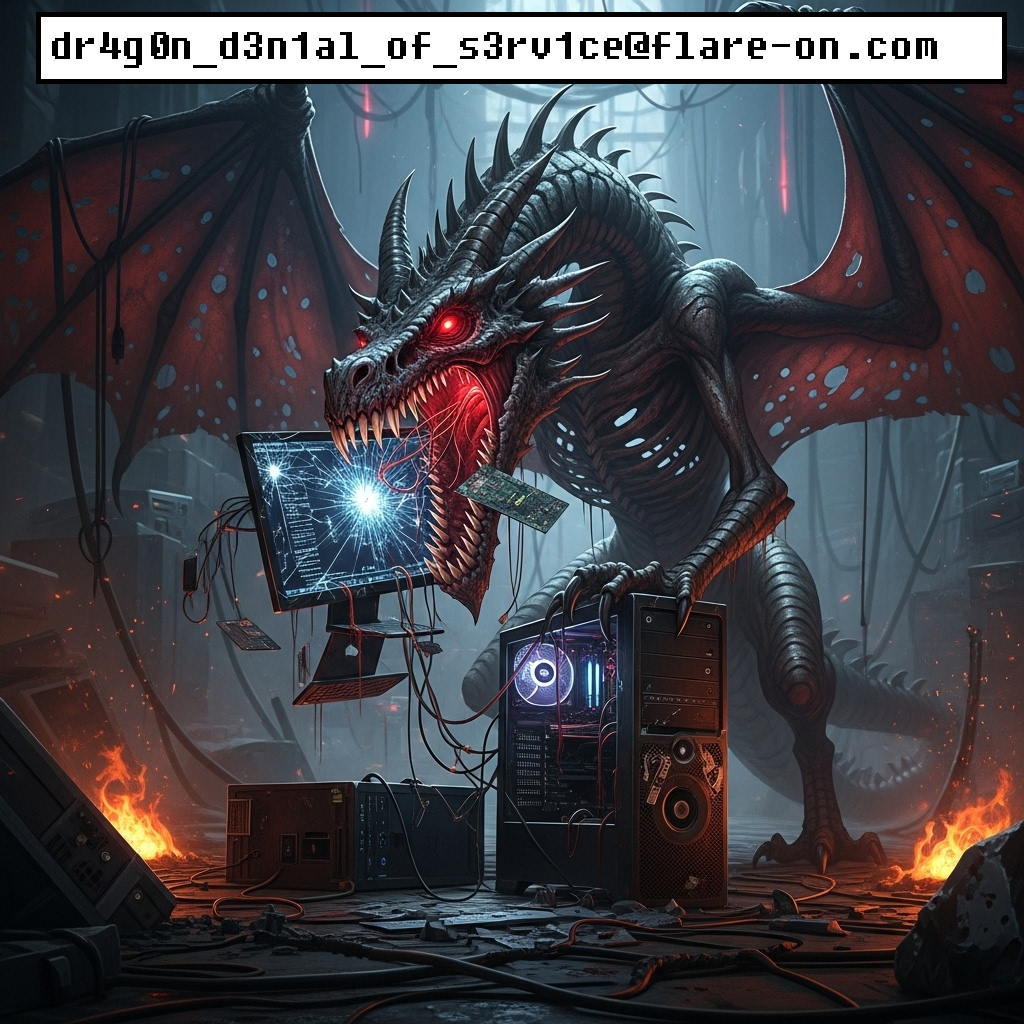

In [29]:
%show flag.png

# Challenge 5 - NTFSM

This challenge is a finite state machine that stores its state in alternate data streams, and the title is an amalgamation of "NTFS" (the file system that has this cursed feature) and "FSM" (finite state machine). Very clever.

In [30]:
%flare v12/5.ntfsm.7z

20.151 MB 50e8bae1b71958d438fbcbd8a26c4d452aded68b2f01b7959ef153d56cc5ba53 ntfsm.exe


The binary contains a large table of 32-bit relative addresses at `0xc687b8` which contain the addresses of each state handler.
Investigating some of the handlers reveals a pattern: The relevant code always starts at offset `0x40` from the beginning of the handler code and consists of a sequence of comparisons. It checks whether the current letter is one of several options and branches to a different state for each one. The correct solution is the (unique) path of length 16 in this decision tree, which we can find quickly using depth-first search.
My solution for this challenge was therefore to parse out the entire tree and then solve for the flag.

While it might be possible to do this in a pipeline in refinery, the number of states is prohibitive with respect to performance and I decided to implement this as a dedicated unit as well. I used the [executable][] module in refinery for easy conversion between addresses and offsets. It also provides a method to construct a capstone disassembler which I used to parse the instructions.

[executable]: https://binref.github.io/lib/executable.html

In [31]:
from refinery.lib.executable import Executable
from refinery.lib import chunks
from refinery.units import Unit


class parse(Unit):
    def __init__(self, start: int = 0xc687b8):
        ...

    def process(self, data):
        mem = memoryview(data)
        exe = Executable.Load(mem, 0)
        cs = exe.disassembler()
        cs.detail = True
        tree = []

        for address in chunks.unpack(exe[self.args.start:], 4):
            if address not in exe:
                break
            address += 0x40
            offset = exe.address_to_offset(address)
            opcodes = cs.disasm(mem[offset:], address, 16)
            edges = []
            next(opcodes)
            next(opcodes)
            for char in opcodes:
                if char.mnemonic != 'cmp':
                    break
                edge = next(opcodes)
                assert edge.mnemonic == 'je'
                edges.append((
                    char.operands[1].imm,
                    edge.operands[0].imm,
                ))
            tree.append(edges)

        def dfs(state=0, depth=0, *chars):
            if depth == 0x10:
                return bytes(chars)
            for char, edge in tree[state]:
                edge = exe.read_integer(edge + 8, size=4)
                if solution := dfs(edge, depth + 1, *chars, char):
                    return solution

        return dfs()

In [32]:
%emit ntfsm.exe | ./parse

iqg0nSeCHnOMPm2Q


It takes a few seconds to run but does find the correct sequence easily once the entire tree is parsed.
The flag is decrypted using AES-CBC, the code for that is in the function at RVA `0xb2a0`. 
It uses the first 16 bytes of the ciphertext as initialization vector and the SHA256 hash of the above string as the key.
The ciphertext is built as a stack string which we can extract using [vstack][].

[vstack]: https://binref.github.io/#refinery.vstack

In [33]:
%emit ntfsm.exe [| push | ./parse | sha256 | pop key | vstack -b0 0xb6cf | aes v:key -i=x::16 ]

f1n1t3_st4t3_m4ch1n3s_4r3_fun@flare-on.com


This pipeline follows a general pattern; use [push][] to back up the content of `ntfsm.exe`, run the custom `parse` unit to extract the key seed, compute its [sha256][] hash, and eventually use [pop][] to make the backed-up copy of the executable data visible again while also storing the key data in a variable named `key`. Next, [vstack][] extracts the encrypted stack string by emulating the code at the given RVA, and finally we use [aes][] to decrypt it. The IV is set using the [multibin][] expression `x::16` which represents the first 16 bytes of the input data and also implies that these 16 bytes will be removed from the input before being processed by [aes][] itself.

[push]: https://binref.github.io/#refinery.push
[pop]: https://binref.github.io/#refinery.pop
[aes]: https://binref.github.io/#refinery.aes
[vstack]: https://binref.github.io/#refinery.vstack
[sha256]: https://binref.github.io/#refinery.sha256
[multibin]: https://binref.github.io/lib/argformats.html

# Challenge 6 - Chain of Demands

In [34]:
%flare v12/6.Chain_of_Demands.7z

32.011 MB 009181f84cd15023714aeadbfbe70fa3eb5d9f1f318265f5bea29411a2f82d7e chat_client


Hey binary refinery, what is the flag?

In [35]:
%%emit chat_client [
    | xt chat_log 
    | push
    | xt 0
    | xj0
    | eat plaintext
    | pad 0x20
    | xor hex:eat:ciphertext
    | pop p:be
    | put d e:pow(0x10001,-1,p-1)
    | xt 8.cipher
    | hex
    | alu -B=256 pow(B,d,p)
    | rev
    | trim h:00 ]

It's W3b3_i5_Gr8@flare-on.com


There's a few things going on here that I'll unpack for you, don't worry.
But first, let us figure out what kind of file this is:

In [36]:
%emit chat_client | peek -ml2

------------------------------------------------------------------------------------------------------------------------
  entropy = 99.94%
    magic = ELF 64-bit LSB executable, x86-64, version 1 (SYSV)
     size = 32.011 MB
------------------------------------------------------------------------------------------------------------------------
000000000: 7F 45 4C 46 02 01 01 00 00 00 00 00 00 00 00 00 02 00 3E 00 01 00 00 00 C0 1C 40  .ELF..............>.......@
00000001B: 00 00 00 00 00 40 00 00 00 00 00 00 00 80 6C E8 01 00 00 00 00 00 00 00 00 40 00  .....@........l..........@.
------------------------------------------------------------------------------------------------------------------------


This kind of entropy on an executable is a pretty reliable hint that it is somehow packed, and the large size on top of that makes me think it is some kind of self-extracting archive. Indeed, it turns out to be a PyInstaller file. The relevant files are the following:

In [37]:
%emit chat_client | xt chat challenge -l

chat_log.json
challenge_to_compile.pyc


This uses the convenient [xt][] unit, which selects and invokes the most appropriate archive extraction unit for the input;
in this case it will defer to the [xtpyi][] unit based on signature checks.
Let's extract the files and dump them to disk:

[xt]: https://binref.github.io/#refinery.xt
[xtpyi]: https://binref.github.io/#refinery.xtpyi

In [38]:
%emit chat_client | xt chat challenge [| dump {path} ]

In [39]:
%ls

32.011 MB 009181f84cd15023714aeadbfbe70fa3eb5d9f1f318265f5bea29411a2f82d7e chat_client
02.540 kB 943f5d7156edd5510c67d941e84369d12aaa6f986cfc7fc2cf6b9d8a2b351892 chat_log.json
33.800 kB d40fdcf9f6c3caef783d5e3344d6f2354d685ef4be02e1525b7bd0040d9b3534 challenge_to_compile.pyc


So this is another Python challenge for which I can recommend [pylingual][] as a decompiler.
Analyzing the script reveals that it is a chat client which can encrypt its messages in one of two modes:
The first is XOR with a sequence of 256-bit keys that are generated by an LCG whose seed is derived from the host name,
the second is multi-prime RSA, the key being constructed from eight 256-bit prime numbers that are generated with the same LCG:

[pylingual]: https://pylingual.io/

In [40]:
%emit chat_log.json | xjl [| xj0 -a | peek -l0 ]

------------------------------------------------------------------------------------------------------------------------
         ciphertext = e934b27119f12318fe16e8cd1c1678fd3b0a752eca163a7261a7e2510184bbe9
  conversation_time = 0
               mode = LCG-XOR
          plaintext = Hello
------------------------------------------------------------------------------------------------------------------------
         ciphertext = 25bf2fd1198392f4935dcace7d747c1e0715865b21358418e67f94163513eae4
  conversation_time = 4
               mode = LCG-XOR
          plaintext = How are you?
------------------------------------------------------------------------------------------------------------------------
         ciphertext = c9f20e5561acf172305cf8f04c13e643c988aa5ab29b5499c93df112687c8c7c
  conversation_time = 11
               mode = LCG-XOR
          plaintext = Terrible...
--------------------------------------------------------------------------------------------------------------------

This pipeline uses two special purpose units [xjl][] and [xj0][] for handling JSON data; the former can unpack JSON lists into multiple refinery frame chunks and the latter extracts content at level 0 into meta variables, which works well with [peek][]'s way of displaying those.

[xjl]: https://binref.github.io/#refinery.xjl
[xj0]: https://binref.github.io/#refinery.xj0
[peek]: https://binref.github.io/#refinery.peek

The web3 angle is that all these operations are implemented in EVM bytecode,
 but you can tell how it works mostly from the function names alone.
The most significant insight that you must have about the LCG is that it will return the initial state in the first iteration,
 which _should_ allow you to recover everything else, including the primes that define the private part of the RSA key.
We can, of course, recover the initial state from the first message because we have the plaintext and the conversation time, both of which are XORed with the key to obtain the ciphertext:
 Computing the XOR of ciphertext, plaintext, and conversation time will therefore yield the key,
 which for the first message is the initial state of the LCG.
Since the conversation time of the first message is zero, we don't even have to XOR with it.
The LCG initial state is:

In [41]:
%emit chat_log.json | xt 0 | xj0 [| eat plaintext | pad 0x20 | xor hex:eat:ciphertext ]| pack -ErRB=32 16

0xA151DE1D76F12318FE16E8CD1C1678FD3B0A752ECA163A7261A7E2510184BBE9


This uses [xt][] again, this time unpacking items from a JSON document, in this case the very first item in the list.
The [eat][] unit consumes a meta variable and replaces the chunk body with its contents, in this case the plaintext data.
We then [pad][] this data with zero bytes (the default) to a length of 0x20 bytes and [xor][] it with the ciphertext.
The result is the LCG initial state, and we use [pack][] in reverse to convert its raw bytes into a hexadecimal integer representation.

[xt]: https://binref.github.io/#refinery.xt
[eat]: https://binref.github.io/#refinery.eat
[pad]: https://binref.github.io/#refinery.pad
[xj0]: https://binref.github.io/#refinery.xj0
[xor]: https://binref.github.io/#refinery.xor
[pack]: https://binref.github.io/#refinery.pack

Very notably, this number is a prime. This means that it must be one of the 8 factors of the RSA key $n=p_1\cdots p_8$. Now the way RSA works is that you are encoding messages as elements of the following ring:
$$
\begin{align*}
\mathbb{Z}_n &\cong \mathbb{Z}_{p_1} \times\cdots\times \mathbb{Z}_{p_8}
\end{align*}
$$
This isomorphism is due to the Chinese Remainder Theorem and the map from left to right is the canonical one, i.e. it reduces a residue class modulo $n$ further modulo $p_i$ for each component. If your message is smaller than, say, $p_1$, this would mean that the projection to the first factor of the product ring on the right hand side is enough to recover it. The 256 bits of each of the $p_i$ correspond do 32 bytes, which is plenty of space to contain a flag, so I thought it worth trying this out.

The implication is that by knowing $p_1$, you can try to compute the modular inverse of $e=65537$ modulo $p_1-1$, i.e.
$$
d\cdot e \equiv 1 + k(p_1-1).
$$
for some $k\in\mathbb{Z}$.
Then take the ciphertext $c\in\mathbb{Z}_n$, compute its projection $c_1\in\mathbb{Z}_{p_1}$, and simply compute $c_1^d$.
If $m_1$ is the projection of the plaintext $m$, you get
$$
c_1^d = (m_1^e)^d = m_1^{ed} = (m_1^{p_1-1})^k \cdot m_1 = 1^k \cdot m_1 = m_1
$$
Now if the assumption is correct and the message is small enough, this should be sufficient to recover the plain text.

This is exactly what we are doing in the initial pipeline: We are extracting the ciphertext from the last chat message.
The first few lines are just to store the first prime in a variable named `p` using [put][].
We then compute the variable `d` by using [put][] with a [multibin][] expression to eval the following Python expression:
```python
pow(0x10001 -1, p-1)
```
We then the ciphertext of message 8 from the chat log JSON file,
 [hex][]-decode the data, and then (ab)use the [alu][] unit to perform the exponentiation:
We set the block size to 256 bytes so it will treat the entire message as one number, and compute $\text{pow}(B,d,p)$ which should yield back the message if we are right.
It works and we get back the flag, but the unit encodes the result in little endian so we have to [rev][]erse the bytes and [trim][] and remaining padding.

[put]: https://binref.github.io/#refinery.put
[alu]: https://binref.github.io/#refinery.alu
[hex]: https://binref.github.io/#refinery.hex
[rev]: https://binref.github.io/#refinery.rev
[trim]: https://binref.github.io/#refinery.trim
[multibin]: https://binref.github.io/lib/argformats.html

In [42]:
%%emit chat_log.json [
    | put p 0xA151DE1D76F12318FE16E8CD1C1678FD3B0A752ECA163A7261A7E2510184BBE9
    | put d eval:pow(0x10001,-1,p-1)
    | xt 8.cipher
    | hex
    | alu -B=256 pow(B,d,p)
    | rev
    | trim h:00 ]

It's W3b3_i5_Gr8@flare-on.com


It's worth noting that this is not how I got the flag. I spent a lot of time trying to recover the LCG parameters to compute all 8 primes.
The problem with this, at least as far as I can tell, is that the code in the challenge was not actually used to generate the parameters.
Instead, you have to first recover the first states of the LCG:

In [43]:
%%emit chat_log.json | xjl [
    | xj0 -a
    | pick :7
    | eat plaintext
    | pad 0x20
    | xor hex:eat:ciphertext
    | xor -EB=32 v:conversation_time
    | pack -ErRB=32 16 ]]

0xA151DE1D76F12318FE16E8CD1C1678FD3B0A752ECA163A7261A7E2510184BBE9
0x6DD058F178F1F7D4EA32BFF17D747C1E0715865B21358418E67F94163513EAE0
0x9D977C2708CE9D171E72D6F04C13E643C988AA5AB29B5499C93DF112687C8C77


0x73CAE987E626055A7291560CAECA61BE4BD8FBFF22E4324440B0C9DEF0288E4B
0x660893EE26544AA9F477586A4F9B6FF853AEF774192018FCBB444649493F6FD5
0x3D0E9BE0DB57ABC0771C288FA4CEAF1A23681C77762068D552795D361B106B75
0x2C419A382877723C968F1BF9C5679817CCD4DA241D4B50BAB99F74F169D456C5


Then you can use a standard technique to recover multiplier, shift, and modulus, 
and then recover all 8 primes using the LCG.
Below is the actual code I wrote to solve this challenge.

In [44]:
from math import gcd, prod
from itertools import islice
from Crypto.Util.number import isPrime


def lcg_params(states):
    N = 0
    for i in range(len(states) - 3):
        x, y, z = [a - b for a, b in zip(
            states[i + 1:i + 4],
            states[i + 0:i + 3])]
        g = z * x - y * y
        N = gcd(g, N)
    x, y, z = states[:3]
    m = z - y
    b = y - x
    d = pow(b, -1, N)
    m = m * d % N
    c = (y - m * x) % N
    return m, c, N

states = [
    0xA151DE1D76F12318FE16E8CD1C1678FD3B0A752ECA163A7261A7E2510184BBE9,
    0x6DD058F178F1F7D4EA32BFF17D747C1E0715865B21358418E67F94163513EAE0,
    0x9D977C2708CE9D171E72D6F04C13E643C988AA5AB29B5499C93DF112687C8C77,
    0x73CAE987E626055A7291560CAECA61BE4BD8FBFF22E4324440B0C9DEF0288E4B,
    0x660893EE26544AA9F477586A4F9B6FF853AEF774192018FCBB444649493F6FD5,
    0x3D0E9BE0DB57ABC0771C288FA4CEAF1A23681C77762068D552795D361B106B75,
    0x2C419A382877723C968F1BF9C5679817CCD4DA241D4B50BAB99F74F169D456C5,
]

m, c, N = lcg_params(states)

print(F'{m=:#x}')
print(F'{c=:#x}')
print(F'{N=:#x}')

def lcg(m: int, c: int, n: int, s: int):
    while True:
        yield s
        s = ((s * m) + c) % n

prng = lcg(m, c, N, states[0])

primes = (k for k in prng if isPrime(k) and k.bit_length() == 256)
primes = list(islice(primes, 8))

phi = prod((p - 1 for p in primes))
e = 65537
n = prod(primes)
d = pow(e, -1, phi)

ct = int.from_bytes(bytes.fromhex(
    '6f70034472ce115fc82a08560bd22f0e7f373e6ef27bca6e4c8f67fedf4031be'
    '23bf50311b4720fe74836b352b34c42db46341cac60298f2fa768f775a9c3da0'
    'c6705e0ce11d19b3cbdcf51309c22744e96a19576a8de0e1195f2dab21a3f1b0'
    'ef5086afcffa2e086e7738e5032cb5503df39e4bf4bdf620af7aa0f752dac942'
    'be50e7fec9a82b63f5c8faf07306e2a2e605bb93df09951c8ad46e5a2572e333'
    '484cae16be41929523c83c0d4ca317ef72ea9cde1d5630ebf6c244803d2dc1da'
    '0a1eefaafa82339bf0e6cf4bf41b1a2a90f7b2e25313a021eafa6234643acb9d'
    '5c9c22674d7bc793f1822743b48227a814a7a6604694296f33c2c59e743f4106'
), 'little')

pt = pow(ct, d, n).to_bytes(32).lstrip(B'\0').decode()
print(pt)


m=0x1919337810cc2fd68946430da81d00e60868547d33f321740f1b988b0db20c72
c=0x8708c5a5e5b369da11c7a68f0acac5211b040eb6b121bce5897496cf392b6c1b
N=0xdab91d7e460d1c607dff2c152c9ca857ce2e317172850612dbb9fe38234aece1
It's W3b3_i5_Gr8@flare-on.com


# Challenge 7 - The Boss Needs Help

This one felt like the one I spent the most time on, but looking at my solve times, it only comes in second place with respect to that metric.
Regardless, I did do a lot of reverse engineering work on this one. We are given a packet capture and a binary that produced the encrypted traffic within:

In [45]:
%flare v12/7.The_Boss_Needs_Help.7z

00.595 MB c60297519cacc95c13313d96468226b16006e48600276f1f6029aad6522bb79e packets.pcapng
04.706 MB 14e60fb48803c06762b4fffdd4e0a2bd2bcac7ae81c92d7393f1198951dbfbbb hopeanddreams.exe


The binary is a 64-bit PE which has been obfuscated with junk code. Very notably, the junk code only uses 32-bit instructions. My approach was therefore to nop out all code in the binary that uses 32-bit registers for too many subsequent instructions. This is, of course, prone to false positives and I knew it would destroy some valid code; I therefore had to go back a few times and add exceptions for edge cases until the code became readable. I would say this worked well enough, but I am not claiming it was the most sophisticated approach. 

The first function that is called is at `140081590`, I named it `initializeSession`. It looks like this in Ghidra:
```c
// %Y%m%d%H
  encryptedString = mw::strings::tls::dateTimeStr();
  decryptedString = mw::strings::xor::dateTimeStr(encryptedString);
  strftime(rawTimeString,0xb,decryptedString,&timeData);
  std::string::init_from_c_string(&timeString,rawTimeString);
  mw::context::getUserID(this,&userID);
  std::string::init_from_concat(&timeAndUserID,&timeString,&userID);
  timeAndUserIDLength = std::string::length(&timeAndUserID);
  memzap(&token,0x18);
  std::vector::init_with_size(&token,timeAndUserIDLength);
  tokenHead = std::vector::getHead(&token);
  mw::digestToToken(&timeAndUserID,tokenHead);
// ...
```
The `digestToToken` function uses a lookup table for converting the `timeAndUserID` string, together with an additional index-based arithmetic shift and XOR. The first order of business is to dump out that table so we can use it later:

In [46]:
%emit hopeanddreams.exe | vsnip 0x14046a540:256 | dump lut

This token is hex-encoded and sent over the wire in the `Bearer` header of the first request to the C2. We can now extract the original time and user ID data from the packet capture:

In [47]:
%%emit packets.pcapng | pcap [
    | pick 0 | rex Bearer.((??hex)) {1} | hex | map lut range:256 | alu (B-1-K)@0x5A | peek -rd | snip 10: | dump uid ]

---------------------------------------------------------------------------------------------------------------[utf8]---
2025082006TheBoss@THUNDERNODE
------------------------------------------------------------------------------------------------------------------------


We will need these strings for decrypting the next packets in the stream, which is why I store the user ID in a file named `uid` for future use. The response packet from the server contains the user string that will be used for subsequent encryption:

In [48]:
%%emit packets.pcapng | pcap [
    | pick 1 | csd hex | map lut range:256 | alu (B-1-K) | xor uid | ppjson | peek -adr ]

---------------------------------------------------------------------------------------------------------------[utf8]---
{
    "sta": "excellent",
    "ack": "peanut@theannualtraditionofstaringatdisassemblyforweeks.torealizetheflagwasjustxoredwiththefilenamethewho...
}
------------------------------------------------------------------------------------------------------------------------


With `peanut`, we can construct the AES key to decrypt the first messages:

In [49]:
%%emit packets.pcapng | pcap [
    | pick 2 | carve-json | xt d | hex | aes xor[sha256:uid]:sha256:peanut06 -i=range:16 | ppjson ]]

{
    "ci": "Architecture: x64, Cores: 2",
    "cn": "THUNDERNODE",
    "hi": "TheBoss@THUNDERNODE",
    "mI": "6143 MB",
    "ov": "Windows 6.2 (Build 9200)",
    "un": "TheBoss"
}


However, the key fails to decrypt all messages. the last message that decrypts correctly is this one:

In [50]:
%%emit packets.pcapng | pcap [
    | pick 2: | carve-json | xt d | hex | aes xor[sha256:uid]:sha256:peanut06 -Qi=range:16 | pick ~0 ]]

{"msg": "cmd", "d": {"cid": 6, "dt": 20, "np": "TheBoss@THUNDERNODE"}}


This is the first message that contains the key `np` inside the `d` field. Digging around the code more, you discover that this is setting a new password for the AES encryption, so the string `TheBoss@THUNDERNODE06` becomes the new seed for the AES key. This will not give us everything either, let's check the last message again.

In [51]:
%%emit packets.pcapng | pcap [
    | pick 2: | carve-json | xt d | hex | aes xor[sha256:uid]:sha256:cca[06]:uid -Qi=range:16 | pick ~0 ]]

{"msg": "cmd", "d": {"cid": 6, "dt": 25, "np": "miami"}}


So one more password, this one is `miami06`. This one can now decrypt all remaining packages:

In [52]:
%%emit packets.pcapng | pcap [
    | pick ~0 | carve-json | xt d | hex | aes xor[sha256:uid]:sha256:miami06 -i=range:16 ]]

{"msg": "cmd", "d": {"cid": 3}}


Studying the pcap, it turns out that there is a fairly large message in phase 2:

In [53]:
%%emit packets.pcapng | pcap [
    | carve-json | xt d | hex | aes xor[sha256:uid]:sha256:cca[06]:uid -Qi=range:16 | max size ]| peek -d

------------------------------------------------------------------------------------------------------------------------
00.259 MB; 75.01% entropy; ASCII text, with very long lines, with no line terminators
---------------------------------------------------------------------------------------------------------------[utf8]---
{"fc":"UEsDBBQAAQAIAERqEltA1H/Ua/UCAAb2AgATAAAAZ3VpdGFyX3NheF9mbGFnLmpwZ82SAqB19AFKUMigdvvA4C8OojUalMLLpIwElEV/C4Mrek...
------------------------------------------------------------------------------------------------------------------------


Let's carve out that base64 string and decode it:

In [54]:
%%emit packets.pcapng | pcap [
    | carve-json | xt d | hex | aes xor[sha256:uid]:sha256:cca[06]:uid -Qi=range:16 | max size ]| csd b64 | peek -l4

------------------------------------------------------------------------------------------------------------------------
00.194 MB; 99.99% entropy; Zip archive data, at least v2.0 to extract
------------------------------------------------------------------------------------------------------------------------
00000: 50 4B 03 04 14 00 01 00 08 00 44 6A 12 5B 40 D4 7F D4 6B F5 02 00 06 F6 02 00 13 00  PK........Dj.[@...k.........
0001C: 00 00 67 75 69 74 61 72 5F 73 61 78 5F 66 6C 61 67 2E 6A 70 67 CD 92 02 A0 75 F4 01  ..guitar_sax_flag.jpg....u..
00038: 4A 50 C8 A0 76 FB C0 E0 2F 0E A2 35 1A 94 C2 CB A4 8C 04 94 45 7F 0B 83 2B 7A 4F 7D  JP..v.../..5........E...+zO}
00054: 19 39 93 CF BA A5 06 73 D5 D6 AC C6 3D B0 7F 15 DF 00 67 5E 6B 23 2F C8 05 F3 7F F5  .9.....s....=.....g^k#/.....
------------------------------------------------------------------------------------------------------------------------


Flag? Let's go!

In [55]:
%%emit packets.pcapng | pcap [
    | carve-json | xt d | hex | aes xor[sha256:uid]:sha256:cca[06]:uid -Qi=range:16 | max size ]| csd b64 | xtzip | peek

(09:50:32) warning in xtzip: extraction failure for guitar_sax_flag.jpg: invalid password; use -L to extract raw encrypted data


Yea that would have been too easy, but I bet the password is somewhere in phase 3 of the c2 traffic.
I blindly attempt to extract the JSON field `fc` from all messages and base64-decode it, assuming the information is in an exfiltrated file:

In [56]:
%%emit packets.pcapng | pcap [
    | carve-json | xt d | hex | aes xor[sha256:uid]:sha256:miami06 -Qi=range:16 | xt fc | b64 ]]

Email: BornToRun!75
Bank: TheRiver##1980
ComputerLogin: TheBossMan
Other: TheBigM@n1942!


Looks good to me. I assume this goes under other?

In [57]:
%%emit packets.pcapng | pcap [
    | carve-json | xt d | hex | aes xor[sha256:uid]:sha256:cca[06]:uid -Qi=range:16 | max size ]
    | csd b64 | xt -p TheBigM@n1942! [| dump {path} ]

In [58]:
%ls

00.595 MB c60297519cacc95c13313d96468226b16006e48600276f1f6029aad6522bb79e packets.pcapng
04.706 MB 14e60fb48803c06762b4fffdd4e0a2bd2bcac7ae81c92d7393f1198951dbfbbb hopeanddreams.exe
00.256 kB 93631b0726f6fe6629daa743ee51b49f4477ed07391b68eeea0672a4a90018aa lut
00.019 kB c30b158c92ffbc95e02b222206cec9676eac6654144e5557a2d97569c11ed8df uid
00.194 MB 277817a12628c78c2ca9550cb2beb831342f0b568cc56ad38d3797aeda84e27b guitar_sax_flag.jpg


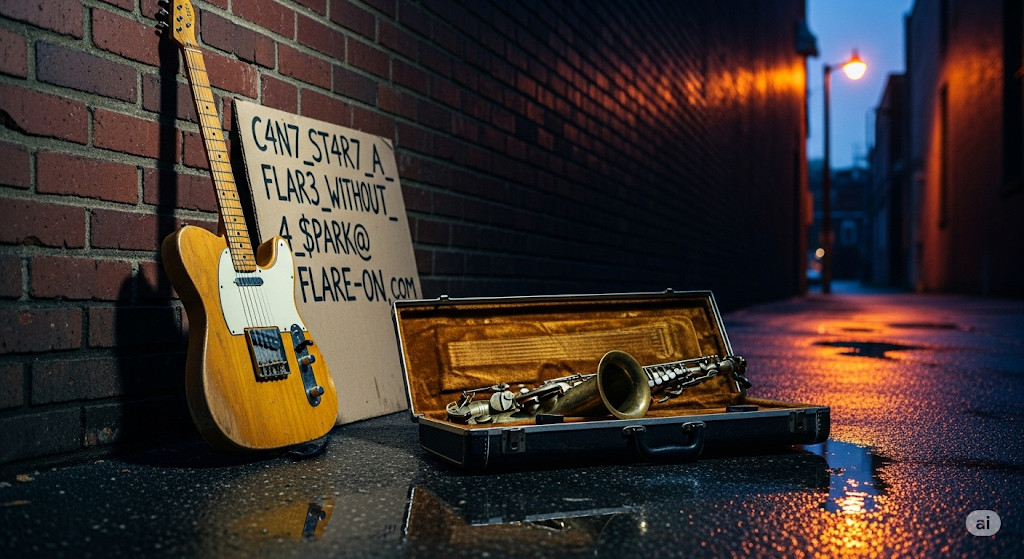

In [59]:
%show guitar_sax_flag.jpg

# Challenge 8 - Flare Authenticator

In [60]:
%flare v12/8.FlareAuthenticator.7z

00.084 kB 8e5f9e7dcd486af8e7f3191d36373d1dc7751f0fdfe627821df03cdcd8550032 run.bat
00.837 MB d5030be9d1ec0edecebc822b7168c210d4e40cff2f4e37cbd14b0f9dbd1d497b FlareAuthenticator.exe
05.793 MB 697026ff2b482df169794bd7b17a41fb47d87a518730588c668045e1f21a53da Qt6Core.dll
08.072 MB 8b56854670882cbf1423929ffe64f22357ce2414ecfe8a6bf041efa8a2408bd1 Qt6Gui.dll
06.026 MB ddce26294eaadd430b9f25f2eaa37a2155e9947882382cc3ed148fa25322c52a Qt6Widgets.dll
00.558 MB 0f885b509a685d2bbfa652fed26b5fb31d88fbdab0a978c641d1c7b8aa460aa9 msvcp140.dll
35.952 kB bfad5aef4c63a669e3c140655cdfdf395b6c979b400a447bd5dcb65ed8826c3d msvcp140_1.dll
00.280 MB 3ea06f0ee098b4823cb79599df3780e7f23cce52c19aac31d2a0d47efe33a5e9 msvcp140_2.dll
00.851 MB 7e273516ab2f0778b8f2f645a854f8ed5535bf712755e94e114c29cd8fa9b7c9 qwindows.dll
00.125 MB d5e4d9a3e835fa679450145d6a7d94e36573a509317111904d9b3712c30d9066 vcruntime140.dll
49.792 kB 1f2d41c4aa5db0bc33ebf7b66d72943a817d7ce6cbe880502a9403823633093f vcruntime140_1.dll


This is an application with a graphical interface where you can type on buttons to enter 25 decimal digits,
 the correct combination of which will yield the flag.
Due to the heavy obfuscation of the executable and the annoying UI angle,
 this one was solved primarily through dynamic analysis.
Using [tiny tracer][tiny] and [x64dbg][], you can eventually figure out that it compares a hash value with the hard-coded constant `0xbc42d5779fec401` before branching to either the message for a success or the one for a failure.

After that, it involved a few more hours of debugging to determine that said hash is updated on each button press,
and the function at `0x140081760` returns the "hash" for the currently pressed button.
The following pseudo-code illustrates how the hash is computed, where I use `F` to represent the function at `0x140081760`.
```python
hash_value = 0
for i in range(1, 25 + 1):
    hash_value += F(i) * F((i << 8) | key[i])
```

[tiny]: https://github.com/hasherezade/tiny_tracer
[x64dbg]: https://x64dbg.com/

At this point I decided to emulate `F` instead of reversing it and to use z3 to solve for the key code. That worked extremely well. My original code was not as neat as the one below and it did, in fact, inspire quite a few changes to refinery's emulator interface. But at the time of writing, the following implementation works:

In [61]:
import z3

from refinery.lib.emulator import UnicornEmulator
from refinery.units import Unit


class solve(Unit):
    def process(self, data):
        emu = UnicornEmulator(data)
        emu.reset()
        end = (1 << emu.exe.pointer_size) - 1
        key = z3.BitVec('key', 25 * 8)
        solver = z3.Solver()
        F = {}

        def uint8(k):
            return (key >> (k * 8)) & 0xFF

        for i in range(25):
            solver.add(0x30 <= uint8(i))
            solver.add(0x39 >= uint8(i))

        def _F(k: int):
            emu.set_return_address(end)
            emu.callarg(1, value=k)
            emu.emulate(0x140081760, end)
            return emu.rv

        for i in range(1, 26):
            F[i] = _F(i)
            for j in range(0x30, 0x3A):
                s = (i << 8) | j
                F[s] = _F(s)

        hashval = 0

        for t in range(25):
            i = t + 1
            shifted = [F[(i << 8) | k] for k in range(0x30, 0x3A)]
            hashval += F[i] * z3.If(
                uint8(t) == 0x30, shifted[0], z3.If(
                    uint8(t) == 0x31, shifted[1], z3.If(
                        uint8(t) == 0x32, shifted[2], z3.If(
                            uint8(t) == 0x33, shifted[3], z3.If(
                                uint8(t) == 0x34, shifted[4], z3.If(
                                    uint8(t) == 0x35, shifted[5], z3.If(
                                        uint8(t) == 0x36, shifted[6], z3.If(
                                            uint8(t) == 0x37, shifted[7], z3.If(
                                                uint8(t) == 0x38, shifted[8], shifted[9])))))))))

        solver.add(hashval == 0xbc42d5779fec401)

        if solver.check() == z3.sat:
            m = solver.model()
            x: z3.BitVecNumRef = m[key]
            t = x.as_long().to_bytes(25, 'little')
            return t

In [62]:
%emit FlareAuthenticator.exe | ./solve

4498291314891210521449296


At this point you can enter the key code in the GUI and obtain the flag, but what would this be without a way to extract it from the binary:

In [63]:
%emit FlareAuthenticator.exe [| push | ./solve | pop key | vsnip -a 0x140097180 | rc4 v:key | cca @flare-on.com ]

s0m3t1mes_1t_do3s_not_m4ke_any_s3n5e@flare-on.com


# Challenge 9 - 10.000

There will not be a lot of refinery in this one, but there's at least a little bit and so I wanted to include it.
Frankly, I also enjoyed this challenge very much.

In [64]:
%flare v12/9.10000.7z

01.157 GB 785a6e2bb7ce9685afe80589bbc7e28b1676e003b0041e1f74e4984044a4e551 10000.exe


The challenge presents as a fairly large PE executable, but the size is almost completely concentrated in the resource section:

In [65]:
%emit 10000.exe | vsect [| sorted size | pf {size!r} {path} ]]

01.156 GB .rsrc
00.830 MB .text
70.656 kB .rdata
67.584 kB .xdata
53.248 kB .data
51.200 kB .pdata
06.144 kB .reloc
04.608 kB .idata
00.512 kB .tls


## Challenge Design Overview

The code is not obfuscated, so after a minor round of reversing, the design of the challenge is straightforward to determine:

- The executable verifies the content of a file named `license.bin` which is expected to be 340.000 bytes in size.
- There are 10.000 DLLs stored in the executable's resource section.
- Each of the modules exposes several functions that can transform a 32-byte buffer, these will be referred to as **transformations**.
- Each of the modules also exports a single function **check** that indicates whether a 32-byte input is correct or not.
- The file `license.bin` consists of 10.000 entries, each consisting of a 16-bit prefix identifying a module by index, and a 32-byte buffer to be verified by that module.
- Every module index must occur exactly once.
- If all 10.000 entries of the file validate correctly, the executable decrypts a buffer using the SHA256 hash of `license.bin` as the key; this buffer is the flag.

The first thing to do is to extract the modules and dump them to disk so you can inspect them. For this demo, I am only extracting the first 4, but removing the invocation of [pick][] from this pipeline will dump them all:

[pick]: https://binref.github.io/#refinery.pick

In [66]:
%emit 10000.exe | perc RCDATA [| pick :4 | aplib | dump dlls/{index:04d}.dll ]

In [67]:
%ls

01.157 GB 785a6e2bb7ce9685afe80589bbc7e28b1676e003b0041e1f74e4984044a4e551 10000.exe
00.380 MB c9443014974926c9c037100d6062c839814b9954be4cee270ac3e7db00a16573 dlls/0000.dll
00.419 MB 691050966f88288f485526ddfedc121f90723abc35e47b44bbc0d24587dfc9a6 dlls/0001.dll
00.407 MB 547f1ee0c0edc768348d78dae62949236a6ec3d59a53f67e334ecba7ae388fe0 dlls/0002.dll
00.389 MB 26959388bd8182f9f7f7b279c83dc63fbb4a95fd176ca42161d285cdc4f33546 dlls/0003.dll


In [68]:
%emit dlls/0000.dll | pemeta -tcH

Header.Machine      : AMD64
Header.Subsystem    : WINDOWS_CUI
Header.MinimumOS    : Windows 95
Header.ExportName   : 0000.real.dll
Header.Type         : DLL
Header.ImageBase    : 0x0000000224130000
Header.ImageSize    : 0x0000000000063000
Header.ComputedSize : 379904
Header.Bits         : 64
Header.EntryPoint   : 0x0000000224131330


## Module Check

The next step is to analyze the modules themselves. The function for checking the buffer is always structured the same way: First, a number of transformations are applied to the input - these can be transformations that are implemented in the module itself, or transformations imported from other modules. After applying all transformations, the 32-byte buffer is used as an XOR key on the columns of a hard-coded $4\times4$ matrix with 64-bit valued entries $M$. The result is $X$. The code then checks whether $X$ has nonzero determinant and then whether
$$
Y = X^e \bmod p
$$
for hard-coded constants $e$, $p$, and a hard-coded $4\times4$ matrix $Y$. The number $p$ is always a prime, so these are matrix operations over a finite field. In order to recover the correct 32 input bytes, we will therefore have to:

- Solve a discrete logarithm problem over $G := \text{GL}(\mathbb{F}_p^4)$, i.e. find the matrix $X$ given $Y$, $e$, and the prime modulus $p$.
- Extract the 32-byte mask by computing the XOR of $X$ and $M$.

This provides opportunity for a sanity check as the XOR of these matrices should be 4 equal columns, each one representing the 32-byte transformed input. Afterwards, there's a few more things we have to do that still require some investigation:

1. Invert the initial sequence of transformations to obtain the correct 32-byte input for passing the check.
2. Do this for all 10.000 modules and determine the order in which they have to be placed in the license file.

It turns out that the transformations come in 3 flavors:

1. A permutation of the byte values, implemented as a 256-byte lookup table
2. A permutation of the indices, implemented as a 32-byte lookup table
3. Exponentiation modulo $2^{256}$, made invertible by forcing the input to be an odd number and then later smuggling back the original lower bit. This transformations is defined by the hard-coded exponent $e$, a big integer encoded in 31 bytes.

Lucky for us, these are indeed all invertible, so it only becomes a matter of parsing the constants and implementing the inverse transformation.

## Module Load Order 

The final piece to the puzzle, at least at the theoretical level, is then to determine the load order of the modules.
Reversing the original executable further, it turns out that the executable maintains a tally:
Whenever a module $m$ is loaded for executing its check, this can cause other modules $D(m)$, its dependencies, to also be loaded.
To simplify the notation, we say that $m\in D(m)$, i.e. $m$ is a dependency of itself.
The tally is then implemented as an array $t=(t_0,\ldots,t_{9999})$ whose entires start out as $0$.
When module $m$ is loaded at position $x$, the binary sets $t_i := t_i + x$ for all $i\in D(m)$.
For a position $x\in[0,9999]$, we will denote by $m(x)$ the module index at this position.
The pseudocode for computing the tally now looks like this:
```text
for x from 0 to 9999:
    for i in D(m(x)):
        t[i] += x
```
In oder to solve for $m(x)$ more easily, we instead think about the inverse permutation: Let $x(m)$ be the position of the module $m$ so $x(m(x)) = x$. Then, we also define
$$
E(i) = \{m \;:\; i\in D(m) \},
$$
the set of **dependants** of a module $i$. The tally computation can then be expressed as follows:
```text
for i from 0 to 9999:
    for m in E(i):
        t[i] += x(m)
```
Or, to visualize this better as a system of equations:
$$
\forall i\in[0,9999]:\quad t_i = \sum_{m\in E(i)} x(m)
$$
Luckily for us, the module dependencies are acyclic, which means that the relationship $m\in E(i)$ for $i\ne m$ defines a DAG (directed acyclic graph) on the integer inteerval $[0, 9999]$. This graph must always have a root, i.e. a vertex of in-degree $0$. Such a vertex corresponds to a module $m$ with $E(m) = \{m\}$, i.e. a module that has no dependants. For such a module, we can recover $x(m) = t_m$. Moving forward recursively, we can now eliminate $x(m)$ from all equations and remove $m$ from the graph. After this operation, we have recovered one module position, reduced the size of the graph by one, and left the situation otherwise unchanged: This means we can repeat this process until we have solved for all module positions.